In [1]:
'''
Text Classification Model trainning 
Steps 
1. Data Loading & Exploration
2. Data Preprocessing
3. Handling Multi-labels
4. Train-Test Split
5. Feature Extraction (TF-IDF, Word Embeddings)
6. Model Training (Multiple approaches)
7. Model Evaluation
8. Hyperparameter Tuning
9. Model Saving
10. Prediction on New Data


libraries 
pip install tensorflow scikit-learn pandas numpy matplotlib seaborn openpyxl xlrd imbalanced-learn --break-system-packages
'''



'\nText Classification Model trainning \nSteps \n1. Data Loading & Exploration\n2. Data Preprocessing\n3. Handling Multi-labels\n4. Train-Test Split\n5. Feature Extraction (TF-IDF, Word Embeddings)\n6. Model Training (Multiple approaches)\n7. Model Evaluation\n8. Hyperparameter Tuning\n9. Model Saving\n10. Prediction on New Data\n\n\nlibraries \npip install tensorflow scikit-learn pandas numpy matplotlib seaborn openpyxl xlrd imbalanced-learn --break-system-packages\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, precision_score, recall_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import re
import warnings
warnings.filterwarnings('ignore')

# For deep learning (optional - neural networks)
try:
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    print("TensorFlow/Keras not available. Will skip deep learning models.")


print("All necessary libraries are imported successfully.")

2026-01-26 23:55:49.151695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-26 23:55:49.844688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-26 23:55:53.831714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


All necessary libraries are imported successfully.


In [4]:
# STEP 1: DATA LOADING & EXPLORATION

def load_and_explore_data(file_path):
    """Load data and perform initial exploration"""
    print("=" * 80)
    print("STEP 1: DATA LOADING & EXPLORATION")
    print("=" * 80)
    
    # Load data
    df = pd.read_excel(file_path)
    
    print(f"\nDataset shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    print(f"\nLabel distribution:")
    print(df['label'].value_counts())
    
    print(f"\nMissing values:")
    print(df.isnull().sum())
    
    print(f"\nText length statistics:")
    df['text_length'] = df['text'].apply(lambda x: len(str(x)))
    print(df['text_length'].describe())
    
    return df


In [5]:
# STEP 2: DATA PREPROCESSING

def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters and digits (optional - depending on your use case)
    # text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [6]:
def handle_multilabels(df, strategy='first'):
    """
    Handle multi-label samples
    
    Strategies:
    - 'first': Take the first label
    - 'remove': Remove multi-label samples
    - 'separate': Create separate samples for each label (data augmentation)
    """
    print("\n" + "=" * 80)
    print("STEP 3: HANDLING MULTI-LABELS")
    print("=" * 80)
    
    # Identify multi-label samples
    multi_label_mask = df['label'].astype(str).str.contains(',')
    multi_label_count = multi_label_mask.sum()
    
    print(f"\nMulti-label samples found: {multi_label_count}")
    print(f"Multi-label samples: {df[multi_label_mask]['label'].unique()}")
    
    if strategy == 'first':
        print("\nStrategy: Taking first label from multi-label samples")
        df['label'] = df['label'].astype(str).apply(lambda x: x.split(',')[0])
        
    elif strategy == 'remove':
        print("\nStrategy: Removing multi-label samples")
        df = df[~multi_label_mask].copy()
        
    elif strategy == 'separate':
        print("\nStrategy: Creating separate samples for each label")
        new_rows = []
        for idx, row in df[multi_label_mask].iterrows():
            labels = str(row['label']).split(',')
            for label in labels:
                new_row = row.copy()
                new_row['label'] = label.strip()
                new_rows.append(new_row)
        
        # Remove original multi-label rows and add new rows
        df = pd.concat([df[~multi_label_mask], pd.DataFrame(new_rows)], ignore_index=True)
    
    # Convert labels to integers
    df['label'] = df['label'].astype(int)
    
    print(f"\nFinal label distribution:")
    print(df['label'].value_counts().sort_index())
    
    return df

In [7]:
# STEP 4: TRAIN-TEST SPLIT
def split_data(df, test_size=0.2, random_state=42, stratify=True):
    """Split data into train and test sets"""
    print("\n" + "=" * 80)
    print("STEP 4: TRAIN-TEST SPLIT")
    print("=" * 80)
    
    X = df['text'].values
    y = df['label'].values
    
    # Use stratified split to maintain class distribution
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
    
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"\nTraining set label distribution:")
    print(pd.Series(y_train).value_counts().sort_index())
    print(f"\nTest set label distribution:")
    print(pd.Series(y_test).value_counts().sort_index())
    
    return X_train, X_test, y_train, y_test


In [8]:
# STEP 5: FEATURE EXTRACTION

def extract_features_tfidf(X_train, X_test, max_features=1000):
    """Extract TF-IDF features"""
    print("\n" + "=" * 80)
    print("STEP 5: FEATURE EXTRACTION (TF-IDF)")
    print("=" * 80)
    
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,  # Ignore terms that appear in less than 2 documents
        max_df=0.8,  # Ignore terms that appear in more than 80% of documents
        ngram_range=(1, 2),  # Use unigrams and bigrams
        stop_words='english'
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    print(f"\nTF-IDF matrix shape (train): {X_train_tfidf.shape}")
    print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
    print(f"Number of features: {len(vectorizer.get_feature_names_out())}")
    
    return X_train_tfidf, X_test_tfidf, vectorizer


In [9]:
# STEP 6: MODEL TRAINING

def train_models(X_train, y_train, X_test, y_test):
    """Train multiple models and compare performance"""
    print("\n" + "=" * 80)
    print("STEP 6: MODEL TRAINING")
    print("=" * 80)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*40}")
        print(f"Training {name}...")
        print(f"{'='*40}")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")
        
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'predictions': y_pred
        }
    
    return results


In [ ]:
# STEP 7: MODEL EVALUATION

def evaluate_best_model(results, y_test):
    """Evaluate and visualize the best model"""
    print("\n" + "=" * 80)
    print("STEP 7: MODEL EVALUATION")
    print("=" * 80)
    
    # Find best model based on F1 weighted score
    best_model_name = max(results, key=lambda k: results[k]['f1_weighted'])
    best_model = results[best_model_name]['model']
    best_predictions = results[best_model_name]['predictions']
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {results[best_model_name]['f1_weighted']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, best_predictions)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\nConfusion matrix saved to: confusion_matrix.png")
    
    return best_model_name, best_model


In [11]:
# STEP 8: HYPERPARAMETER TUNING
def tune_hyperparameters(X_train, y_train, model_type='logistic'):
    """Perform hyperparameter tuning"""
    print("\n" + "=" * 80)
    print("STEP 8: HYPERPARAMETER TUNING")
    print("=" * 80)
    
    if model_type == 'logistic':
        model = LogisticRegression(max_iter=1000, random_state=42)
        param_grid = {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'class_weight': ['balanced', None]
        }
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'class_weight': ['balanced', None]
        }
    else:
        raise ValueError("model_type must be 'logistic' or 'random_forest'")
    
    print(f"\nTuning {model_type} model...")
    print(f"Parameter grid: {param_grid}")
    
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5,  # 5-fold cross-validation
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


In [12]:
# STEP 9: MODEL SAVING

def save_model(model, vectorizer, filepath_model, filepath_vectorizer):
    """Save trained model and vectorizer"""
    print("\n" + "=" * 80)
    print("STEP 9: SAVING MODEL")
    print("=" * 80)
    
    import pickle
    
    # Save model
    with open(filepath_model, 'wb') as f:
        pickle.dump(model, f)
    print(f"\nModel saved to: {filepath_model}")
    
    # Save vectorizer
    with open(filepath_vectorizer, 'wb') as f:
        pickle.dump(vectorizer, f)
    print(f"Vectorizer saved to: {filepath_vectorizer}")


def load_model(filepath_model, filepath_vectorizer):
    """Load saved model and vectorizer"""
    import pickle
    
    with open(filepath_model, 'rb') as f:
        model = pickle.load(f)
    
    with open(filepath_vectorizer, 'rb') as f:
        vectorizer = pickle.load(f)
    
    return model, vectorizer


In [13]:
# STEP 10: PREDICTION ON NEW DATA

def predict_new_data(model, vectorizer, new_texts):
    """Predict labels for new text data"""
    print("\n" + "=" * 80)
    print("STEP 10: PREDICTION ON NEW DATA")
    print("=" * 80)
    
    # Preprocess
    new_texts_processed = [preprocess_text(text) for text in new_texts]
    
    # Vectorize
    new_texts_tfidf = vectorizer.transform(new_texts_processed)
    
    # Predict
    predictions = model.predict(new_texts_tfidf)
    
    # Get prediction probabilities (if available)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(new_texts_tfidf)
        
        for i, (text, pred, prob) in enumerate(zip(new_texts, predictions, probabilities)):
            print(f"\nText {i+1}: {text[:100]}...")
            print(f"Predicted Label: {pred}")
            print(f"Confidence: {max(prob):.4f}")
    else:
        for i, (text, pred) in enumerate(zip(new_texts, predictions)):
            print(f"\nText {i+1}: {text[:100]}...")
            print(f"Predicted Label: {pred}")
    
    return predictions


TEXT CLASSIFICATION MODEL TRAINING PIPELINE
STEP 1: DATA LOADING & EXPLORATION

Dataset shape: (177, 4)

Columns: ['id', 'text', 'similarity_score', 'label']

First few rows:
        id                                               text  \
0  1g4a7ot  Burn out among Cybersecurity leaders at a frus...   
1  1dqiog2  Invitation to Participate in Research Study on...   
2  1g49xt4  Dealing with feeling stuck in the security fie...   
3  1fqxn7a  How are you doing guys?\nIs this cybersecurity...   
4  1fbdhwo  Hey folks, for those of you working right now,...   

   similarity_score label  
0          0.437536     1  
1          0.400815     0  
2          0.281245     0  
3          0.316323     1  
4          0.377892     2  

Label distribution:
label
0      107
1       38
2        8
6        6
3        3
9        3
7        3
5        2
7,8      2
4        2
4,8      1
2,9      1
1,4      1
Name: count, dtype: int64

Missing values:
id                  0
text                0
similari

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/confusion_matrix.png'

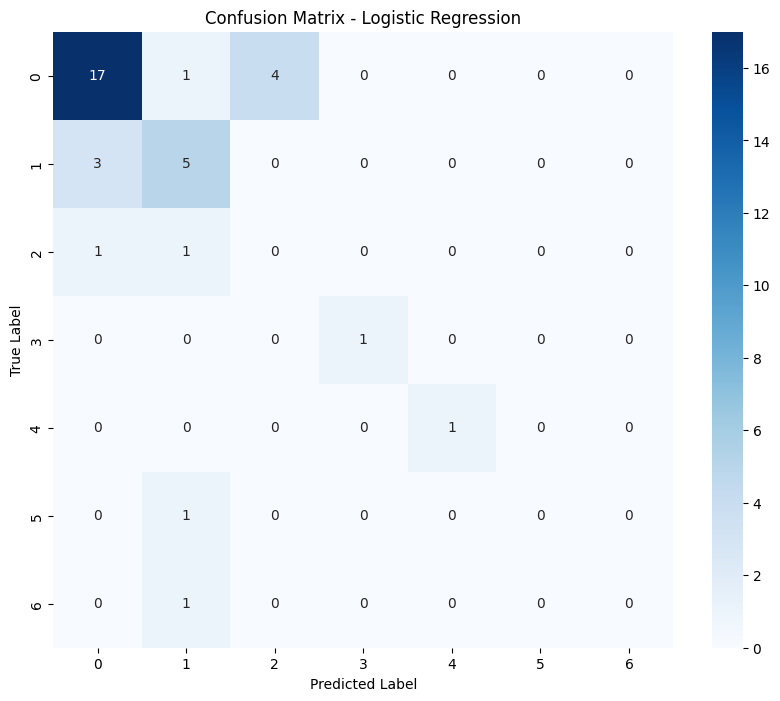

In [14]:
# MAIN PIPELINE
def main():
    """Run the complete classification pipeline"""
    
    print("\n" + "=" * 80)
    print("TEXT CLASSIFICATION MODEL TRAINING PIPELINE")
    print("=" * 80)
    
    # File path
    data_path = 'manual_label_batch1.xlsx'
    
    # Step 1: Load data
    df = load_and_explore_data(data_path)
    
    # Step 2: Preprocess text
    print("\n" + "=" * 80)
    print("STEP 2: TEXT PREPROCESSING")
    print("=" * 80)
    df['text_processed'] = df['text'].apply(preprocess_text)
    print("\nSample preprocessed text:")
    print(df['text_processed'].iloc[0])
    
    # Step 3: Handle multi-labels
    df = handle_multilabels(df, strategy='first')  # Change strategy as needed
    
    # Step 4: Split data
    X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)
    
    # Preprocess train and test texts
    X_train_processed = [preprocess_text(text) for text in X_train]
    X_test_processed = [preprocess_text(text) for text in X_test]
    
    # Step 5: Feature extraction
    X_train_tfidf, X_test_tfidf, vectorizer = extract_features_tfidf(
        X_train_processed, X_test_processed, max_features=500
    )
    
    # Step 6: Train models
    results = train_models(X_train_tfidf, y_train, X_test_tfidf, y_test)
    
    # Step 7: Evaluate best model
    best_model_name, best_model = evaluate_best_model(results, y_test)
    
    # Step 8: Hyperparameter tuning (optional - can be slow)
    print("\nWould you like to perform hyperparameter tuning? (Recommended for better results)")
    print("Skipping for now - you can uncomment the lines below to enable it")
    # tuned_model = tune_hyperparameters(X_train_tfidf, y_train, model_type='logistic')
    # y_pred_tuned = tuned_model.predict(X_test_tfidf)
    # print("\nTuned Model Results:")
    # print(classification_report(y_test, y_pred_tuned))
    
    # Step 9: Save model
    save_model(
        best_model, 
        vectorizer, 
        'best_model.pkl',
        'vectorizer.pkl'
    )
    
    # Step 10: Test prediction on new data
    sample_texts = [
        "I'm experiencing severe burnout in my cybersecurity role",
        "Looking for recommendations on IT career development",
        "Just got a new security analyst position, very excited!"
    ]
    
    predictions = predict_new_data(best_model, vectorizer, sample_texts)
    
    print("\n" + "=" * 80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print("\nNext steps:")
    print("1. Review the confusion matrix: confusion_matrix.png")
    print("2. Use the saved model for predictions: best_model.pkl")
    print("3. Consider collecting more data for underrepresented classes")
    print("4. Experiment with different preprocessing and feature extraction methods")
    print("5. Try deep learning models if you have more data")


if __name__ == "__main__":
    main()
